## Given astrometry and photometry for stars from one SDSS run/camcol/field,
## derive astrometric offsets for this field using Gaia EDR3 astrometry  

In [312]:
%matplotlib inline
from astropy.io import ascii 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy.signal import savgol_filter

<a id='dataReading'></a>

### Define paths and catalogs 

In [3]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Data"
# Gaia EDR3 with BP and RP data
GaiaEDR3Cat = ZIdataDir + "/" + "Stripe82_GaiaEDR3full.dat" 
# if you don't have the above file, copy it as: 
# http://faculty.washington.edu/ivezic/sdss/calib82/dataV2/Stripe82_GaiaEDR3full.dat

<a id='dataReading'></a>

### Read Gaia EDR3 data for Stripe 82 region

In [4]:
colnamesGaia = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra0', 'pmdec0']
colnamesGaia = colnamesGaia + ['BPmag', 'BPeI', 'RPmag', 'RPeI', 'BRef']
colnamesGaia = colnamesGaia + ['pi', 'piErr', 'pmra', 'pmraErr', 'pmdec', 'pmdecErr', 'Nobs']
gaia = Table.read(GaiaEDR3Cat, format='ascii', names=colnamesGaia)
gaia['raG'] = gaia['ra']
gaia['decG'] = gaia['dec']    
gaia['GmagErr'] = gaia['fluxErr'] / gaia['flux'] 
gaia['BR'] = gaia['BPmag'] - gaia['RPmag'] 

## New analysis to support Sarah's work 

In [335]:
# robust standard deviation
def sigG(arr):
    return 0.741*(np.quantile(arr, 0.75)-np.quantile(arr, 0.25))

def selectGaiaFromStripe82Field(s, g):
    # find RA and Dec extremes for s, and then return g elements 
    # that have RA and Dec within these limits
    # assume SDSS Stripe 82, extending from RA<0 to RA>0
    ra = s['ra'] 
    raW = np.where(ra > 180, ra-360, ra) 
    Rmin = np.min(raW)
    Rmax = np.max(raW)
    dec = s['dec']
    Dmin = np.min(dec)
    Dmax = np.max(dec)
    ra = g['ra'] 
    raW = np.where(ra > 180, ra-360, ra) 
    dec = g['dec']
    return g[(raW>=Rmin)&(raW<=Rmax)&(dec>=Dmin)&(dec<=Dmax)] 

def selectGoodMatches(s, g, maxOffsetArcsec = 0.5):
    # here we do proper astrometric matching (not assuming Stripe 82)
    sdssCoords = SkyCoord(ra = s['ra']*u.degree, dec= s['dec']*u.degree) 
    gaiaCoords = SkyCoord(ra = g['ra']*u.degree, dec= g['dec']*u.degree) 
    idx, d2d, d3d = sdssCoords.match_to_catalog_sky(gaiaCoords)  
    matches = hstack([s, g[idx]], table_names = ['sdss', 'gaia'])
    matches['sep_2d_arcsec'] = d2d.arcsec
    # good matches must be closer than this limit:
    return matches[(matches['sep_2d_arcsec'] < maxOffsetArcsec)]

def getAstrometricOffsets(m, doPM=1.0):
    ## this is the main work horse that 
    ## 1) defines "robust" subsample
    ## 2) computes "offset" quantities for this field 
    ## NB The Gaia EDR3 epoch is 2016.0, which is 
    gaiaMJD = 57388  
    offsets={}
    offsets['Nstars'] = len(m)
    # define robust subsample
    giMin = 0.0
    giMax = 3.0 
    rMin = 14.5
    rMax = 21.0
    mx = m[(m['gi']>=giMin)&(m['gi']<=giMax)&(m['r']>=rMin)&(m['r']<=rMax)] 
    # additional constraint on proper motion from Gaia (in milliarcsec/yr)
    mOK = mx[(np.abs(mx['pmra'])<500)&(np.abs(mx['pmdec'])<500)]
    offsets['NstarsOK'] = len(mOK)
    if (len(mOK)>0):
        # compute offsets: predicted position RAgaia + pm*(mjdGaia-mjdSDSS)
        # units for proper motion from Gaia: milliarcsec/yr
        dMJD = gaiaMJD - mOK['mjd']
        dRA = getGaiaSDSSoffset(mOK['ra_sdss'], mOK['ra_gaia'], mOK['pmra'], dMJD)
        dDec = getGaiaSDSSoffset(mOK['dec_sdss'], mOK['dec_gaia'], mOK['pmdec'], dMJD)
        offsets['medianRAarcsec'] = np.median(dRA)
        offsets['medianDecarcsec'] = np.median(dDec)
        offsets['sigRAarcsec'] = sigG(dRA)
        offsets['sigDecarcsec'] = sigG(dDec)
    else:
        offsets = getDefaultOffsets(len(m), 0)
        dRA = 0*m['ra_gaia'] 
        dDec = 0*m['ra_gaia'] 
    return offsets 

def getGaiaSDSSoffset(sdssCoord, gaiaCoord, gaiaPM, dMJD, doPM=1.0):
    return 3600*(gaiaCoord - sdssCoord) - doPM * 0.001* gaiaPM * dMJD / 365.25

def getDefaultOffsets(Nstars=-1, NstarsOK=-1):
    offsets={}
    offsets['Nstars'] = Nstars
    offsets['NstarsOK'] = NstarsOK
    offsets['medianRAarcsec'] = 0
    offsets['medianDecarcsec'] = 0
    # large enough (in arcsec) that it doesn't matter
    offsets['sigRAarcsec'] = 9.99
    offsets['sigDecarcsec'] = 9.99
    return offsets 

def getOffsetsForField(sdssCatFile, gaiaDF):
    
    try:
        data = ascii.read(sdssCat) 
    except OSError:
        print('using defaults; cannot open', sdssCatFile)
        return getDefaultOffsets() 

    if (len(data)<=0):
        return getDefaultOffsets()
    fields = {'ra': data['col2'],
          'dec': data['col3'],
          'mjd': data['col4'],
          'g': data['col30'],
          'r': data['col31'],
          'i': data['col32']
         }
    sdss = Table(fields)
    sdss['gi'] = sdss['g'] - sdss['i']
    # Gaia EDR3 data for one field
    gaiaField = selectGaiaFromStripe82Field(sdss, gaiaDF)
    if (len(gaiaField)>0):
        matches = selectGoodMatches(sdss, gaiaField)
    else:
        return getDefaultOffsets()
    if (len(matches)>0):
        return getAstrometricOffsets(matches)
    else:
        return getDefaultOffsets() 

    
def smoothOffsets(fields, Ns, NsOK, mRA, mDec, sRA, sDec, plotName):
    
    if (1): 
        # interpolate with cubic spline (from scipy)
        smoothRAfunc = interpolate.interp1d(fields, mRA, 'cubic')
        smoothRA = smoothRAfunc(fields)
        smoothDecfunc = interpolate.interp1d(fields, mDec, 'cubic')
        smoothDec = smoothDecfunc(fields)
    else:
        # smooth with Savitzky-Golay filter
        windowWidth = 3
        polyOrder = 1
        smoothRA = savgol_filter(mRA, windowWidth, polyOrder)  
        smoothDec = savgol_filter(mRA, windowWidth, polyOrder)  

    # plot
    makeOffsetPlot(fields, Ns, NsOK, mRA, mDec, sRA, sDec, smoothRA, smoothDec, plotName)
    return smoothRA, smoothDec 

def makeOffsetPlot(fields, Ns, NsOK, mRA, mDec, sRA, sDec, smoothRA, smoothDec, plotName):

    fig = plt.figure(figsize=(10, 15))
    fig.subplots_adjust(hspace=0, bottom=0.15, left=0.15)

    # upper panel: the number of stars and good stars
    ax = fig.add_subplot(511)
    ax.set_xlim(fields[0]-5, fields[-1]+5)
    ax.set_ylim(0, np.max(Ns)*1.1)

    ax.plot(fields, Ns, c='r', lw=1)
    ax.plot(fields, NsOK, c='b', lw=1)
    ax.set_ylabel('Nstars, NstarsOK')
    ax.set_xlim(fields[0]-5, fields[-1]+5)
    ax.text(np.min(fields),np.max(Ns)*1.15, plotName)

    # middle top: RA offsets
    ax = fig.add_subplot(512)
    ax.errorbar(fields, 1000*mRA, 1000*sRA/np.sqrt(1+NsOK), fmt='.k', lw=1, ecolor='gray')
    ax.plot(fields, 1000*smoothRA, lw=1, c='b')
    ax.plot(fields, 0*fields, lw=1, c='gray')
    ax.set_xlim(fields[0]-1, fields[-1]+1)
    ax.set_xlim(fields[0]-5, fields[-1]+5)
    ax.set_ylabel(r'dRA (milliasec)')

    # middle: RA offsets
    ax = fig.add_subplot(513)
    ax.errorbar(fields, 1000*mDec, 1000*sDec/np.sqrt(1+NsOK), fmt='.k', lw=1, ecolor='gray')
    ax.plot(fields, 1000*smoothDec, lw=1, c='b')
    ax.plot(fields, 0*fields, lw=1, c='gray')
    ax.set_xlim(fields[0]-5, fields[-1]+5)
    ax.set_ylabel(r'dDec (milliasec)')

    # middle bottom: RA scatter
    ax = fig.add_subplot(514)
    ax.plot(fields, 1000*sRA, lw=1, c='b')
    ax.set_xlim(fields[0]-5, fields[-1]+5)
    ax.set_ylim(0, 100)
    ax.set_ylabel(r'RA rms (milliasec)')

    # middle bottom: Dec scatter
    ax = fig.add_subplot(515)
    ax.plot(fields, 1000*sDec, lw=1, c='b')
    ax.set_ylabel(r'Dec rms (milliasec)')
    ax.set_xlim(fields[0]-5, fields[-1]+5)
    ax.set_ylim(0, 100)
    ax.set_xlabel('field')

    fig.savefig(plotName+'.png')
    # plt.show()
    return 

In [191]:
runDataDir = "/Users/ivezic/Work/Science/CalibrationV2/DataAll/RunDir"
# SDSS cat file for one field
sdssCat = runDataDir + "/" + "2709/1/photoObj-002709-1-0040.cat" 
data = ascii.read(sdssCat) 
fields = {'ra': data['col2'],
          'dec': data['col3'],
          'mjd': data['col4'],
          'g': data['col30'],
          'r': data['col31'],
          'i': data['col32']
         }
sdss = Table(fields)
sdss['gi'] = sdss['g'] - sdss['i']
print(len(sdss))

763


In [192]:
# Gaia EDR3 data for one field
gaiaField = selectGaiaFromStripe82Field(sdss, gaia)

In [193]:
print(len(gaia), len(gaiaField))

2526361 109


In [210]:
matches = selectGoodMatches(sdss, gaiaField)
print(len(gaiaField), len(matches))

109 105


In [211]:
if (len(matches)>0):
    offsets = getAstrometricOffsets(matches)
else:
    offsets = getDefaultOffsets()
offsets

{'Nstars': 105,
 'NstarsOK': 75,
 'medianRAarcsec': 0.028178716396128567,
 'medianDecarcsec': -0.021522123058537942,
 'sigRAarcsec': 0.01833789202729644,
 'sigDecarcsec': 0.01214561394592913}

CAMERA COLUMN: 1
median and rms for RA offsets (arcsec): 3.885313417423264e-05 0.03937711669229975
median RA rms (arcsec): 0.01859861611245305
median and rms for Dec offsets (arcsec): -0.0036585208801539343 0.03843847737669813
median Dec rms (arcsec): 0.02221584917947086
made plot offsets-2709-1
CAMERA COLUMN: 2
median and rms for RA offsets (arcsec): -0.004835551714791775 0.03855765135520722
median RA rms (arcsec): 0.017270451855465847
median and rms for Dec offsets (arcsec): -0.009942257307918118 0.03479216371288152
median Dec rms (arcsec): 0.021037693798841545
made plot offsets-2709-2
CAMERA COLUMN: 3
median and rms for RA offsets (arcsec): -0.00467284878012619 0.0332146525757543
median RA rms (arcsec): 0.01720709288001478
median and rms for Dec offsets (arcsec): 0.006652739311467357 0.03175384567713484
median Dec rms (arcsec): 0.0200835522768119
made plot offsets-2709-3
using defaults; cannot open /Users/ivezic/Work/Science/CalibrationV2/DataAll/RunDir/2709/4/photoObj-002709-4-0250

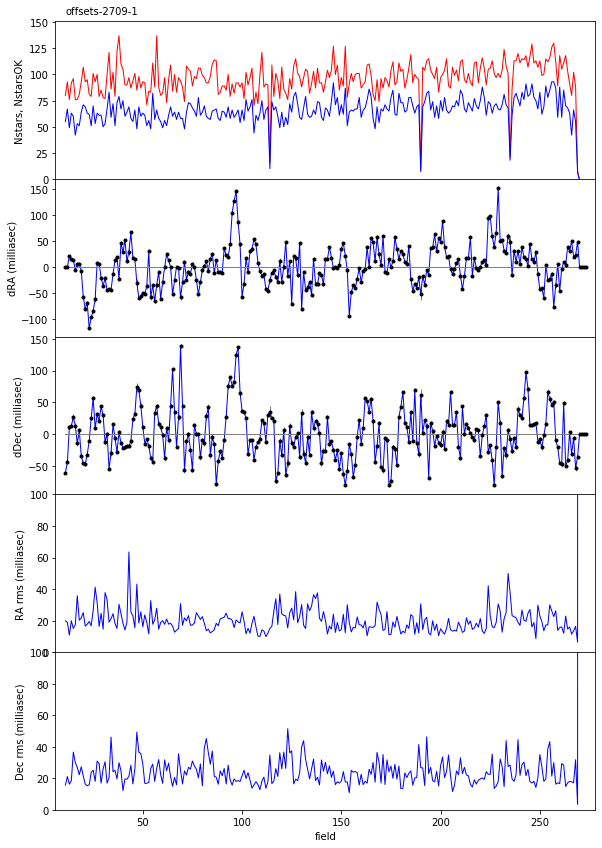

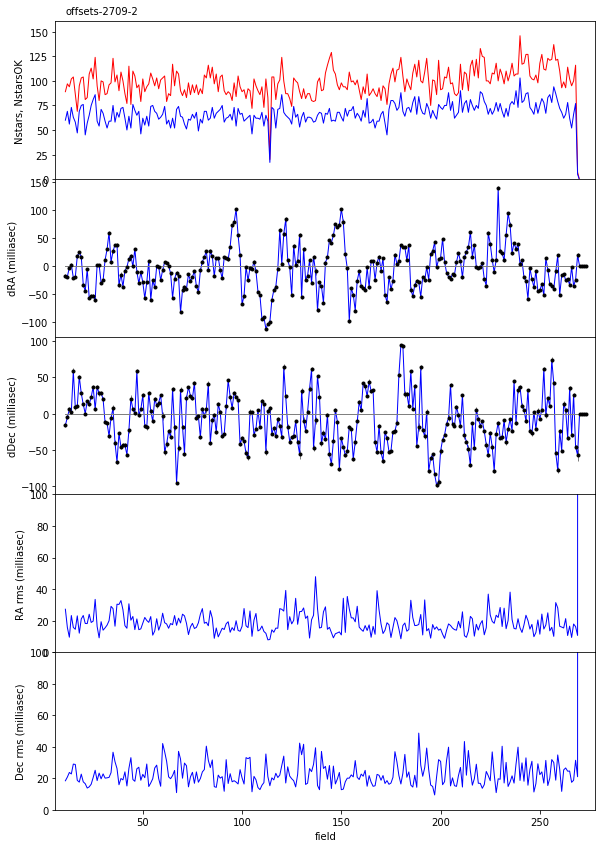

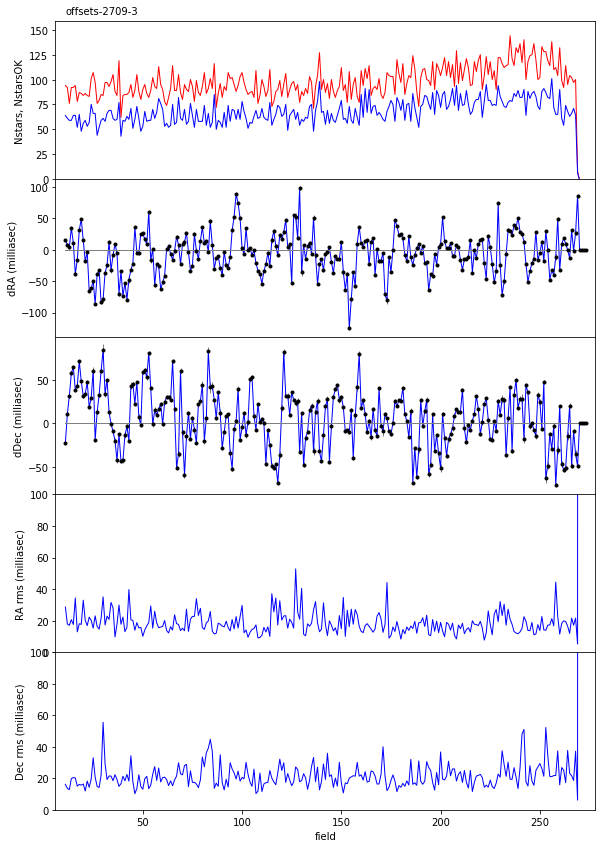

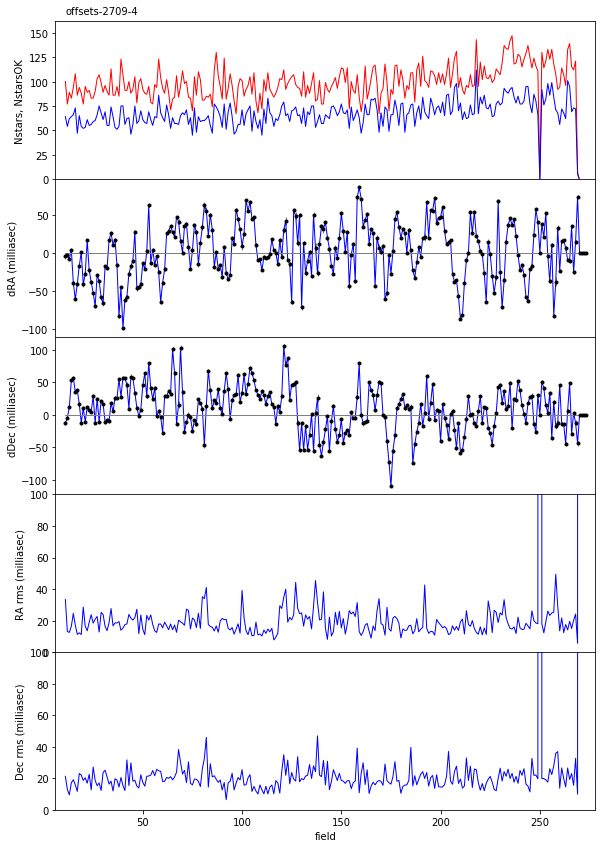

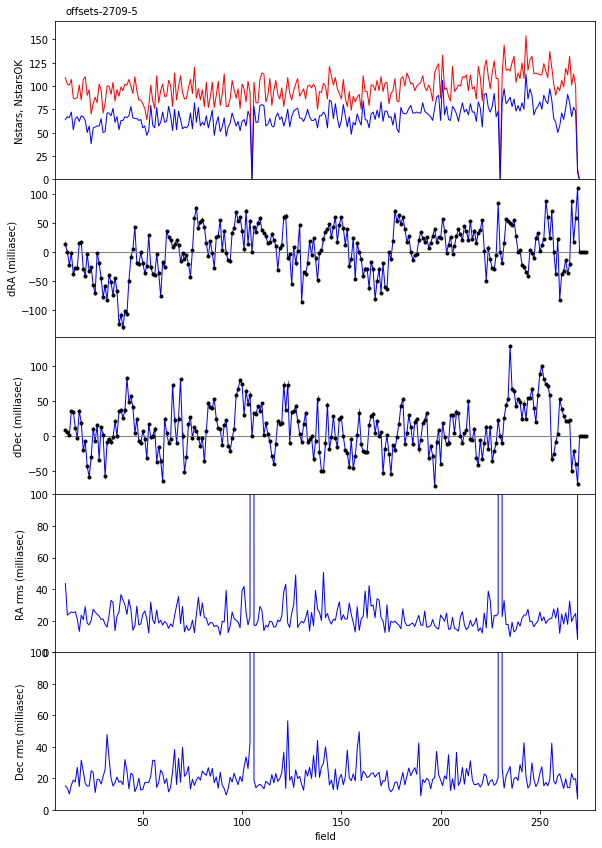

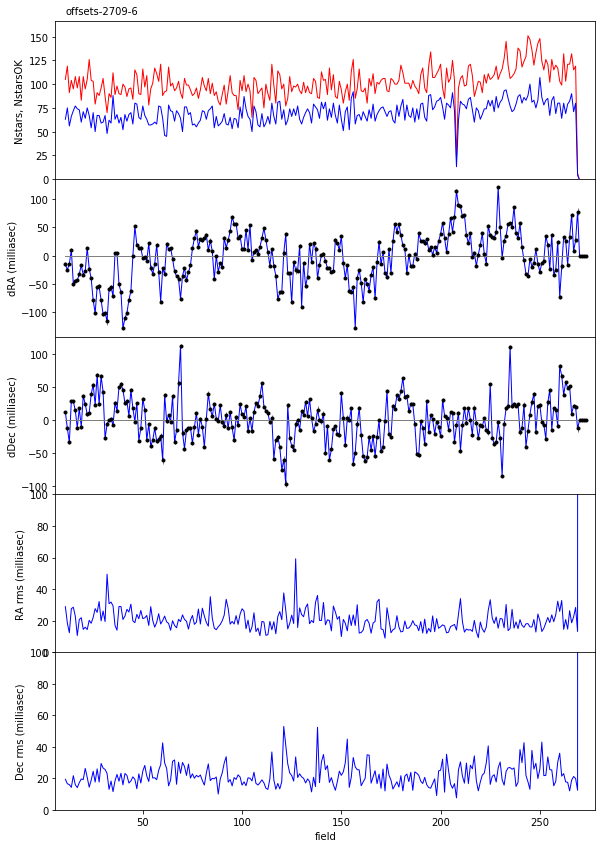

In [336]:
## final wrapper for all 6 camera columns 
##  (though it only makes plots and doesn't store results)
run = 2709
camcol = 1
fieldMin = 11
fieldMax = 273 
# allocate numpy arrays for output
Nfields = fieldMax - fieldMin + 1
fields = np.zeros(Nfields)
Ns = np.zeros(Nfields)
NsOK = np.zeros(Nfields)
mRA = np.zeros(Nfields)
mDec = np.zeros(Nfields)
sRA = np.zeros(Nfields)
sDec = np.zeros(Nfields) 
for camcol in range(1,7):
    for field in range(fieldMin, fieldMax+1):
        CatFile = "/%d/%d/photoObj-%06d-%d-%04d.cat" % (run,camcol,run,camcol,field)
        sdssCat = runDataDir + "/%d/%d/photoObj-%06d-%d-%04d.cat" % (run,camcol,run,camcol,field) 
        offsets = getOffsetsForField(sdssCat, gaia)
        fields[field-fieldMin] = field
        Ns[field-fieldMin] = offsets['Nstars']
        NsOK[field-fieldMin] = offsets['NstarsOK']
        mRA[field-fieldMin] = offsets['medianRAarcsec']
        mDec[field-fieldMin] = offsets['medianDecarcsec']
        sRA[field-fieldMin] = offsets['sigRAarcsec']
        sDec[field-fieldMin] = offsets['sigDecarcsec']
    plotName = 'offsets-%d-%d' % (run,camcol)
    smoothRA, smoothDec = smoothOffsets(fields, Ns, NsOK, mRA, mDec, sRA, sDec, plotName)
    print('CAMERA COLUMN:', camcol)
    print('median and rms for RA offsets (arcsec):', np.median(mRA), np.std(mRA))
    print('median RA rms (arcsec):', np.median(sRA))
    print('median and rms for Dec offsets (arcsec):', np.median(mDec), np.std(mDec))
    print('median Dec rms (arcsec):', np.median(sDec))
    print('made plot', plotName)

In [337]:
# SDSScorrectedRA = SDSSrawRA + smoothRA / 3600.0
# SDSScorrectedDec = SDSSrawDec + smoothDec / 3600.0
# but need quality cuts, so apply the above only if all of these are OK:
#  - both medianRAarcsec and medianDecarcsec below 0.3 arcsec
#  - both sigRAarcsec and sigDecarcsec below 0.1 arcsec
#  - NstarsOK > 10 
# if not satisfied, do not apply any correction and flag that field as bad 
# strictly speaking, one should add in quadrature to astrometric errors 
# (before fitting proper motions), 
# RA: sigRAarcsec/sqrt(NstarsOK), Dec: sigDecarcsec/sqrt(NstarsOK)
# but in practice these values are typically smaller (<5 milliarcsec)
# than random error in SDSS astrometry (>10 milliarcsec)